In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utilities import load_face_data, make_meshgrid
from svm import MultiClassSVM

import numpy as np
from itertools import combinations, product
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from pandas_ml import ConfusionMatrix
from sklearn.decomposition import PCA
from time import time
from sklearn.preprocessing import scale
%matplotlib inline

In [3]:
faces, labels = load_face_data('face.mat')
print(faces.shape, labels.shape)

(520, 2576) (520,)


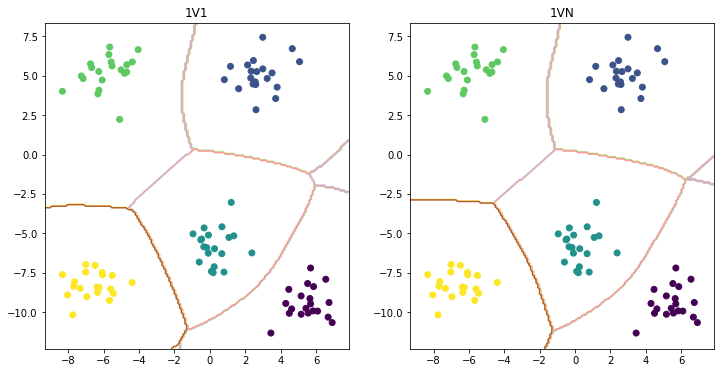

In [29]:
x, y = make_blobs(n_samples=100, n_features=2, centers=5, random_state=10) # create toy data
c, g, kernel, coef0 = 100, 0.1, 'rbf', 1 # set SVM params

# Create plot figure
f, axarr = plt.subplots(1, 2, sharey=False, figsize=(12,6))

# Run 1V1 SVM
svm = MultiClassSVM(C = c, kernel = kernel, gamma = g, fit_type = '1v1', coef0=coef0)
svm.fit(x, y)

# Generate Data
xx, yy = make_meshgrid(x[:, 0], x[:, 1], h=0.1)

# Plot 1V1 Results
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
axarr[0].contour(xx, yy, Z, cmap=plt.cm.Paired)
axarr[0].scatter(x[:, 0], x[:, 1], c = y)
axarr[0].set_title('1V1')

# Run 1VN SVM
svm = MultiClassSVM(C = c, kernel = kernel, gamma = g, fit_type = '1vN', coef0=coef0)
svm.fit(x, y)

# Plot 1VN Results
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
axarr[1].contour(xx, yy, Z, cmap=plt.cm.Paired)
axarr[1].scatter(x[:, 0], x[:, 1], c = y)
axarr[1].set_title('1VN')
plt.show()

# Data Setup

In [5]:
raw_train_faces, raw_test_faces, train_labels, test_labels = train_test_split(faces, labels, test_size=0.2)

train_mean = np.mean(raw_train_faces, axis = 0)
train_std = np.std(raw_train_faces, axis = 0)
train_faces = (raw_train_faces - train_mean) / train_std
test_faces = (raw_test_faces - train_mean) / train_std
printstat = lambda n, d, l: print('{} set size: {}, # {} classes: {}'.format(n, len(d), n, len(np.unique(l))))
printstat('training', train_faces, train_labels)
printstat('testing', test_faces, test_labels)

training set size: 416, # training classes: 52
testing set size: 104, # testing classes: 44


In [6]:
pca = PCA(n_components=0.95)
transformed_train_faces = pca.fit_transform(train_faces)
transformed_test_faces = pca.transform(test_faces)
print('Original dimensionality: {}, Dimensionality for 95% explained variance: {}'.format(
    train_faces.shape[1], transformed_train_faces.shape[1])
     )

Original dimensionality: 2576, Dimensionality for 95% explained variance: 129


### Search Parameters

In [7]:
Cs = np.logspace(0, 3, num = 4)
gammas = np.logspace(-6, -1, num = 6)
noise_pixel = np.random.rand(*train_faces.shape)
noise_pca = np.random.rand(*transformed_train_faces.shape)

# One Vs. N
## No PCA

In [8]:
rbf_param_grid = {'C': Cs, 'gamma': gammas, 'kernel': ['rbf'], 'fit_type': ['1vN']}
linear_param_grid = {'C': Cs, 'kernel': ['linear'], 'fit_type': ['1vN']}

In [9]:
print('#################  1VN - RBF  ##################\n')
t = time()
clf = GridSearchCV(MultiClassSVM(), rbf_param_grid, n_jobs = -1)
clf.fit(train_faces, train_labels)
print('best parameters: {}'.format(clf.best_params_))
print('validation accuracy: {}'.format(clf.best_score_))
print('Mean time per iteration: {} seconds'.format((time() - t) / len(Cs) / len(gammas)))
t = time()
clf.predict(noise_pixel)
print('Inference time: {}'.format(time() - t))

print('################# 1VN - LINEAR ##################\n')
t = time()
clf = GridSearchCV(MultiClassSVM(), linear_param_grid, n_jobs = -1)
clf.fit(train_faces, train_labels)
print('best parameters: {}'.format(clf.best_params_))
print('validation accuracy: {}'.format(clf.best_score_))
print('Mean time per iteration: {} seconds'.format((time() - t) / len(Cs)))
t = time()
clf.predict(noise_pixel)
print('Inference time: {}'.format(time() - t))

#################  1VN - RBF  ##################

best parameters: {'C': 1000.0, 'fit_type': '1vN', 'gamma': 1.0000000000000001e-05, 'kernel': 'rbf'}
validation accuracy: 0.7932692307692307
Mean time per iteration: 12.430900891621908 seconds
Inference time: 3.048258066177368
################# 1VN - LINEAR ##################

best parameters: {'C': 1.0, 'fit_type': '1vN', 'kernel': 'linear'}
validation accuracy: 0.7980769230769231
Mean time per iteration: 3.9746896624565125 seconds
Inference time: 2.910764694213867


## PCA

In [10]:
print('#################  1VN - RBF  ##################\n')
t = time()
clf = GridSearchCV(MultiClassSVM(), rbf_param_grid, n_jobs = -1)
clf.fit(transformed_train_faces, train_labels)
print('best parameters: {}'.format(clf.best_params_))
print('validation accuracy: {}'.format(clf.best_score_))
print('Mean time per iteration: {} seconds'.format((time() - t) / len(Cs) / len(gammas) ))
t = time()
clf.predict(noise_pca)
print('Inference time: {}'.format(time() - t))

print('################# 1VN - LINEAR ##################\n')
t = time()
clf = GridSearchCV(MultiClassSVM(), linear_param_grid, n_jobs = -1)
clf.fit(transformed_train_faces, train_labels)
print('best parameters: {}'.format(clf.best_params_))
print('validation accuracy: {}'.format(clf.best_score_))
print('Mean time per iteration: {} seconds'.format((time() - t) / len(Cs)))
t = time()
clf.predict(noise_pca)
print('Inference time: {}'.format(time() - t))

#################  1VN - RBF  ##################

best parameters: {'C': 1000.0, 'fit_type': '1vN', 'gamma': 1.0000000000000001e-05, 'kernel': 'rbf'}
validation accuracy: 0.7860576923076923
Mean time per iteration: 0.46739938855171204 seconds
Inference time: 0.12484335899353027
################# 1VN - LINEAR ##################

best parameters: {'C': 1.0, 'fit_type': '1vN', 'kernel': 'linear'}
validation accuracy: 0.7908653846153846
Mean time per iteration: 0.5675020813941956 seconds
Inference time: 0.1057882308959961


# One Vs. One
## No PCA

In [11]:
rbf_param_grid = {'C': Cs, 'gamma': gammas, 'kernel': ['rbf'], 'fit_type': ['1v1']}
linear_param_grid = {'C': Cs, 'kernel': ['linear'], 'fit_type': ['1v1']}

In [12]:
print('#################  1V1 - RBF  ##################\n')
t = time()
clf = GridSearchCV(MultiClassSVM(), rbf_param_grid, n_jobs = -1)
clf.fit(train_faces, train_labels)
print('best parameters: {}'.format(clf.best_params_))
print('validation accuracy: {}'.format(clf.best_score_))
print('Mean time per iteration: {} seconds'.format((time() - t) / len(Cs) / len(gammas)))
t = time()
clf.predict(noise_pixel)
print('Inference time: {}'.format(time() - t))
    
print('################# 1V1 - LINEAR ##################\n')
t = time()
clf = GridSearchCV(MultiClassSVM(), linear_param_grid, n_jobs = -1)
clf.fit(train_faces, train_labels)
print('best parameters: {}'.format(clf.best_params_))
print('validation accuracy: {}'.format(clf.best_score_))
print('Mean time per iteration: {} seconds'.format((time() - t) / len(Cs)))
t = time()
clf.predict(noise_pixel)
print('Inference time: {}'.format(time() - t))

#################  1V1 - RBF  ##################

best parameters: {'C': 1000.0, 'fit_type': '1v1', 'gamma': 9.9999999999999995e-07, 'kernel': 'rbf'}
validation accuracy: 0.6899038461538461
Mean time per iteration: 9.266814221938452 seconds
Inference time: 20.984505891799927
################# 1V1 - LINEAR ##################

best parameters: {'C': 1.0, 'fit_type': '1v1', 'kernel': 'linear'}
validation accuracy: 0.6899038461538461
Mean time per iteration: 10.097657203674316 seconds
Inference time: 20.60372543334961


## PCA

In [13]:
print('#################  1V1 - RBF  ##################\n')
t = time()
clf = GridSearchCV(MultiClassSVM(), rbf_param_grid, n_jobs = -1)
clf.fit(transformed_train_faces, train_labels)
print('best parameters: {}'.format(clf.best_params_))
print('validation accuracy: {}'.format(clf.best_score_))
print('Mean time per iteration: {} seconds'.format((time() - t) / len(Cs) / len(gammas)))
t = time()
clf.predict(noise_pca)
print('Inference time: {}'.format(time() - t))
    
print('################# 1V1 - LINEAR ##################\n')
t = time()
clf = GridSearchCV(MultiClassSVM(), linear_param_grid, n_jobs = -1)
clf.fit(transformed_train_faces, train_labels)
print('best parameters: {}'.format(clf.best_params_))
print('validation accuracy: {}'.format(clf.best_score_))
print('Mean time per iteration: {} seconds'.format((time() - t) / len(Cs)))
t = time()
clf.predict(noise_pca)
print('Inference time: {}'.format(time() - t))

#################  1V1 - RBF  ##################

best parameters: {'C': 100.0, 'fit_type': '1v1', 'gamma': 1.0000000000000001e-05, 'kernel': 'rbf'}
validation accuracy: 0.6923076923076923
Mean time per iteration: 0.9368569354216257 seconds
Inference time: 1.1540701389312744
################# 1V1 - LINEAR ##################

best parameters: {'C': 1.0, 'fit_type': '1v1', 'kernel': 'linear'}
validation accuracy: 0.6899038461538461
Mean time per iteration: 1.2022090554237366 seconds
Inference time: 0.9500284194946289


# Final Result

Test set prediction time: 0.02857184410095215
Test recognition accuracy: 0.8846153846153846


c:\users\rameg\miniconda2\envs\patternrec\lib\site-packages\pandas_ml\confusion_matrix\abstract.py:66: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  df = df.loc[idx, idx.copy()].fillna(0)  # if some columns or rows are missing


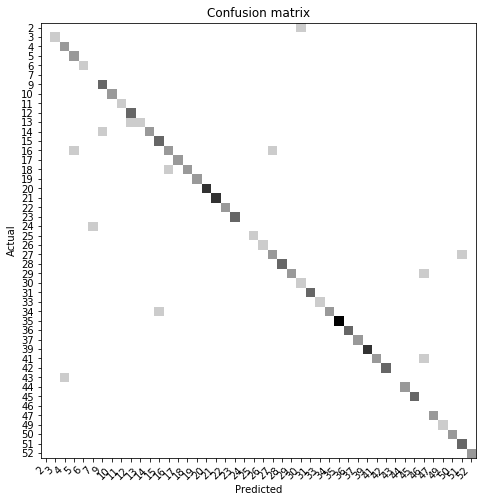

In [14]:
svm = MultiClassSVM(C=1, kernel='linear', gamma=1e-5, fit_type='1vN')
svm.fit(transformed_train_faces, train_labels)

start = time()
test_preds = svm.predict(transformed_test_faces)
print('Test set prediction time: {}'.format(time() - start))
print('Test recognition accuracy: {}'.format(np.mean(test_preds == test_labels)))
confusion_matrix = ConfusionMatrix(test_labels, test_preds)
confusion_matrix.plot()

## Success / Failures

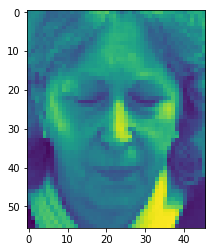

ground truth: [14]
predicted labels: [9]


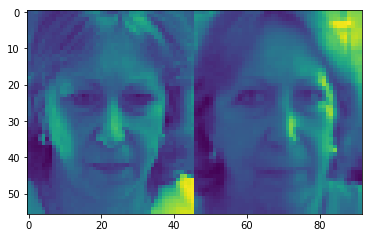

ground truth: [14 14]
predicted labels: [14 14]


In [18]:
selector = test_labels == 14
selected_test_labels = test_labels[selector]
relevant_predicted_labels = test_preds[selector]
relevant_test_faces = raw_test_faces[selector]

correct_selector = selected_test_labels == relevant_predicted_labels
wrong_selector = np.logical_not(correct_selector)
wrongs = relevant_test_faces[wrong_selector]
corrects = relevant_test_faces[correct_selector]

plt.imshow(np.vstack(wrongs.reshape(-1, 46, 56)).T)
plt.show()

print('ground truth: {}'.format(selected_test_labels[wrong_selector]))
print('predicted labels: {}'.format(relevant_predicted_labels[wrong_selector]))

plt.imshow(np.vstack(corrects.reshape(-1, 46, 56)).T)
plt.show()

print('ground truth: {}'.format(selected_test_labels[correct_selector]))
print('predicted labels: {}'.format(relevant_predicted_labels[correct_selector]))

###### Class 14 ######


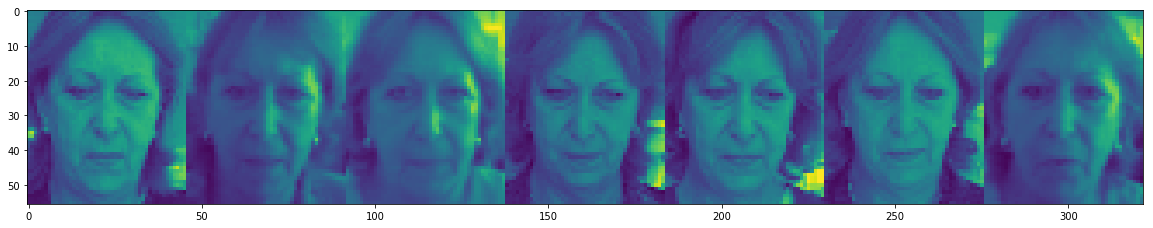

## 37 Support Vectors  ##
number of different classes for SV: 18


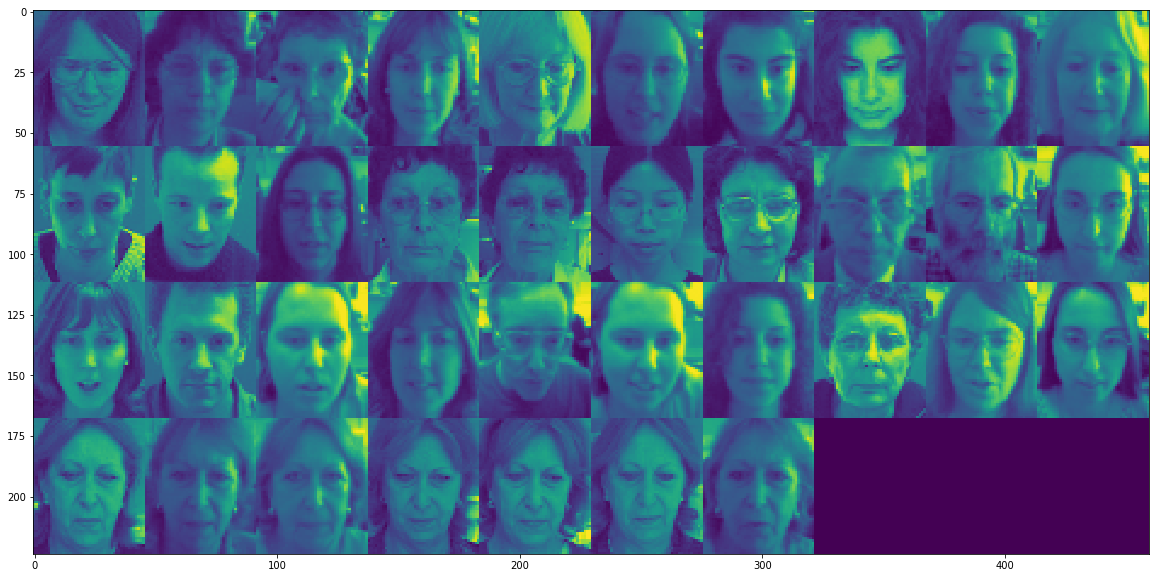

In [19]:
def disp_pair_and_support_1v1(data, labels, l1, l2, support_indices):
    l1_d = data[labels == l1]
    l2_d = data[labels == l2]
    both = np.concatenate((l1_d, l2_d))
    
    print("###### Class {} ######".format(l1))
    plt.figure(figsize=(20,10))
    plt.imshow(np.vstack(l1_d.reshape(-1, 46, 56)).T)
    plt.show()
    print("###### Class {} ######".format(l2))
    plt.figure(figsize=(20,10))
    plt.imshow(np.vstack(l2_d.reshape(-1, 46, 56)).T)
    plt.show()
    print("## Support Vectors  ##")
    plt.figure(figsize=(20,10))
    plt.imshow(np.vstack(both[support_indices].reshape(-1, 46, 56)).T)
    plt.show()
    
def disp_pair_and_support_1vN(data, labels, l, support_indices, side_size = 5):
    l_d = data[labels == l]
    
    print("###### Class {} ######".format(l))
    plt.figure(figsize=(20,10))
    plt.imshow(np.vstack(l_d.reshape(-1, 46, 56)).T)
    plt.show()
    print("## {} Support Vectors  ##".format(len(support_indices)))
    plt.figure(figsize=(20,10))
    ims = np.concatenate((
        data[support_indices], 
        np.ones((side_size - data[support_indices].shape[0] % side_size, 2576))
    ))
    ims = ims.reshape(-1, side_size, 46, 56)
    ims = np.concatenate(ims, axis = 2)
    ims = np.concatenate(ims, axis = 0)
    print('number of different classes for SV: {}'.format(len(np.unique(train_labels[support_indices]))))
    plt.imshow(ims.T)
    
c = 14
disp_pair_and_support_1vN(raw_train_faces, train_labels, c, svm.svms[c].support_, side_size = 10)

In [22]:
print(np.mean([len(s.support_) for i, s in svm.svms.items()]))

34.0769230769
